In [24]:
import torch
import lightning
from mlcolvar.cvs import BaseCV
from mlcolvar.core import FeedForward

import sys
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)
sys.path.append("..")
from loss_and_models import *
from descriptors import *

In [25]:
import numpy as np
from mlcolvar.data import DictModule, DictDataset
from mlcolvar.utils.io import create_dataset_from_files, load_dataframe
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
opes = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/psi/COLVAR_driver',
                      start=250000,stop=None, stride=1)

bias =np.loadtxt("/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/psi/COLVAR")[250000:,-5]


In [26]:

X = opes.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
kT = 2.49432
logweights = bias / kT
dataset = DictDataset({"data":X[::70].values, "weights":np.exp(logweights[::70])})#30 2500 epochs


In [27]:
dataset["data"].shape

torch.Size([27086, 30])

In [28]:

datamodule = DictModule(dataset, lengths=[0.8,0.2],random_split=True,shuffle=True)



In [29]:
dataset["data"] = dataset["data"].to(device)
dataset["weights"] = dataset["weights"].to(device)

In [30]:
masses = np.array([12.011,12.011,15.999,14.0067,12.011,12.011,12.011,15.999,14.0067,12.011])
n_atoms = 10
gamma = 1/0.05
friction = np.zeros(n_atoms*3)
print(friction.shape)
for i_atom in range(10):
    friction[3*i_atom:3*i_atom+3] = np.array([kT / (gamma*masses[i_atom])]*3) 
cell = torch.Tensor([4.0,4.0,4.0]).to(device)
#cell = torch.ones(91*3).to(device)*3.961
friction = torch.tensor(friction, device=device)

(30,)


In [31]:

model_psi = torch.load("model_alanine_psi.pt").to(device)
model_phi = torch.load("model_alanine_phi.pt").to(device)
model_comm =  torch.jit.load('models/model_committor.pt').to(device)


In [32]:
opes_exp = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes_exp/COLVAR_driver',
                      start=0,stop=None, stride=1)
bias = np.loadtxt('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes_exp/COLVAR')[:,-5]
opes_simple = load_dataframe('/home/tdevergne@iit.local/Documents/generator_learning/alanine_datasets/opes/COLVAR',
                      start=0,stop=None, stride=1)
X = opes_exp.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
X_simple = opes_simple.filter(regex='p[0-9]\.[xyz]|p[0-9][0-9]\.[xyz]')
weights = np.exp(bias/kT)


In [33]:
distances =  opes_exp.filter(regex='x[0-9]|x[0-9][0-9]')

In [34]:
distances_tensor = torch.tensor(distances.values[::2], dtype=torch.float32, device=device)
committor = model_comm(distances_tensor)

In [35]:
dataset["data"].shape

torch.Size([27086, 30])

In [36]:
from loss_and_models import compute_eigenfunctions

train_dataset_phi = DictDataset({"data":X[::2].values, "weights":weights[::2]})
valid_dataset_phi = DictDataset({"data":X[::2].values, "weights":weights[::2]})
train_dataset_phi["data"] = train_dataset_phi["data"].to(device)
train_dataset_phi["weights"] = train_dataset_phi["weights"].to(device)
valid_dataset_phi["data"] = valid_dataset_phi["data"].to(device)
valid_dataset_phi["weights"] = valid_dataset_phi["weights"].to(device)

evals_psi, evecs_psi = compute_eigenfunctions(model_psi, dataset, friction, 0.05,3)
evals_phi, evecs_phi = compute_eigenfunctions(model_phi, train_dataset_phi, friction, 0.05,3)
g_psi_psi = model_psi(dataset["data"]) @ evecs_psi.real
g_psi_phi = model_psi(valid_dataset_phi["data"]) @ evecs_psi.real
g_phi_phi = model_phi(valid_dataset_phi["data"]) @ evecs_phi.real
model_phi = model_phi.to(device)
model_psi = model_psi.to(device)

In [37]:
g_psi_phi[:,2] =  2 * (g_psi_phi[:,2] - g_psi_phi[:,2].min()) / (g_psi_phi[:,2].max() - g_psi_phi[:,2].min()) - 1 
g_phi_phi[:,2] = 2 * (g_phi_phi[:,2] - g_phi_phi[:,2].min()) / (g_phi_phi[:,2].max() - g_phi_phi[:,2].min()) - 1
g_psi_phi[:,0] = 2 * (g_psi_phi[:,0] - g_psi_phi[:,0].min()) / (g_psi_phi[:,0].max() - g_psi_phi[:,0].min()) - 1
g_phi_phi[:,0] = 2 * (g_phi_phi[:,0] - g_phi_phi[:,0].min()) / (g_phi_phi[:,0].max() - g_phi_phi[:,0].min()) - 1

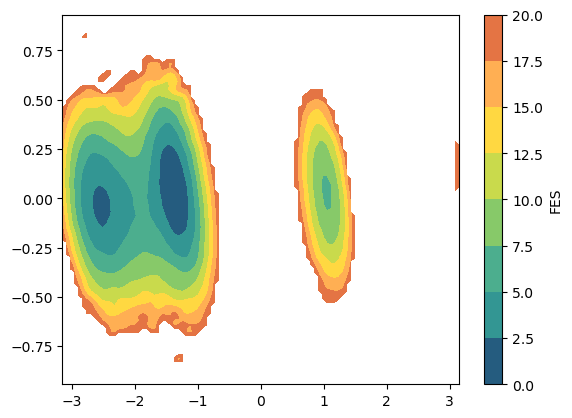

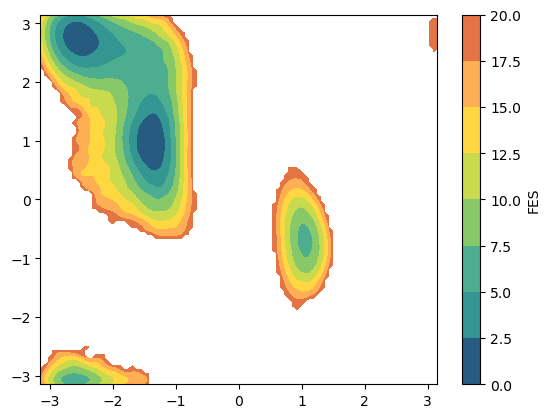

In [38]:
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.plot import *
import matplotlib.pyplot as plt
fes_theta,grid_theta,bounds,error = compute_fes(np.stack((opes_exp["phi"].values,opes_exp["theta"])).swapaxes(1,0),
                                    weights=weights,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, eps=1e-10,temp=300)
fes_psi,grid_psi,bounds,error = compute_fes(np.stack((opes_exp["phi"].values,opes_exp["psi"])).swapaxes(1,0),
                                    weights=weights,
                                    blocks=1,
                                    bandwidth=0.01, scale_by='range',
                                    plot=True, plot_max_fes=20, eps=1e-10,temp=300)

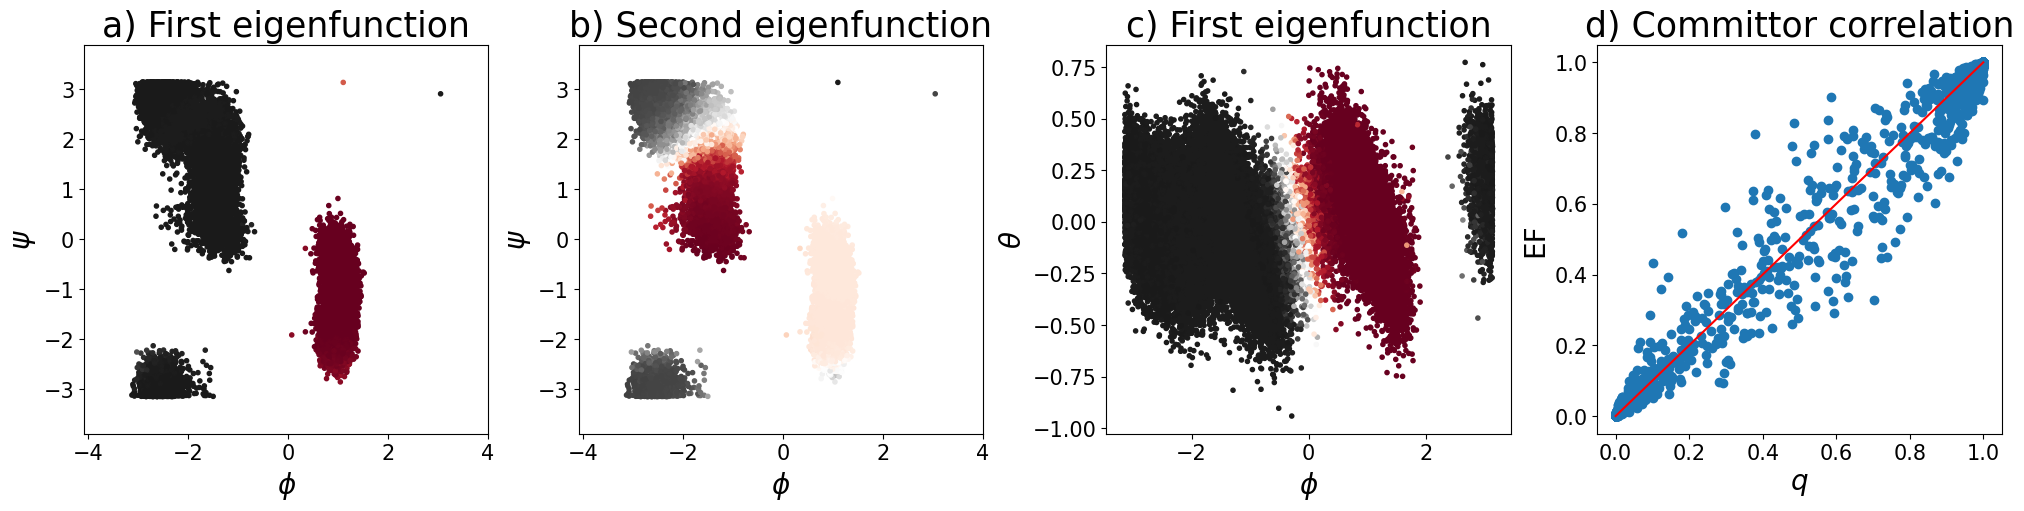

: 

In [39]:
fig, axs = plt.subplots(ncols=4, figsize=(20,5),constrained_layout=True)
axs[0].scatter(opes["phi"].values[::70],opes["psi"].values[::70],c=g_psi_psi[:,2].cpu().detach(),cmap="RdGy",marker=".")
axs[0].set_title("a) First eigenfunction",fontsize=25)
axs[0].set_xlabel("$\phi$",fontsize=20)
axs[0].set_ylabel("$\psi$",fontsize=20)
axs[0].axis("equal")
axs[1].scatter(opes["phi"].values[::70],opes["psi"].values[::70],c=g_psi_psi[:,0].cpu().detach(),cmap="RdGy",marker=".")
axs[1].set_xlabel("$\phi$",fontsize=20)
axs[1].set_ylabel("$\psi$",fontsize=20)
axs[1].axis("equal")

axs[1].set_title("b) Second eigenfunction",fontsize=25)
axs[2].scatter(opes_exp["phi"].values[::2],opes_exp["theta"].values[::2],c=g_psi_phi[:,2].cpu().detach(),cmap="RdGy",marker=".")
axs[2].set_xlabel("$\phi$",fontsize=20)
axs[2].set_ylabel("$\\theta$",fontsize=20)
axs[2].set_title("c) First eigenfunction",fontsize=25)
axs[3].scatter(committor.cpu().detach(),(g_phi_phi[:,2].cpu().detach()+1)/2)
axs[3].plot(np.linspace(0,1,100),np.linspace(0,1,100),c="r")
axs[3].set_title("d) Committor correlation",fontsize=25)
axs[3].set_ylabel("EF",fontsize=20)
axs[3].set_xlabel("$q$",fontsize=20)
#cbar = fig.colorbar(im3, ax=axs[2], orientation='vertical')
#cbar.ax.tick_params(labelsize=10)
for ax in axs.flat:
    ax.tick_params(axis="x",labelsize=15)
    ax.tick_params(axis="y",labelsize=15)